<a href="https://colab.research.google.com/github/stigsfoot/datascience-2023/blob/main/Fighting_AI_Bias_With_Bias_Talk_BiasTesting_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fairlearn
!pip install fairlearn matplotlib
!pip install fairlearn matplotlib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult

## Data Prep


In [ ]:
data = fetch_adult(as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']
sex.value_counts()


Male      32650
Female    16192
Name: sex, dtype: int64

## Setting up a Classifier

In [ ]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score

In [ ]:
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)
y_pred = classifier.predict(X)
mf = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sex)
mf.overall

result = mf.by_group

print(result)


sex
Female    0.925148
Male      0.804288
Name: accuracy_score, dtype: float64


## Analyze results

**Checking the Selection Rate to understand possible bias in the system**

In [ ]:
from fairlearn.metrics import selection_rate
sr = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sex)
sr.overall

result = sr.by_group
print (result)


sex
Female    0.063550
Male      0.213599
Name: selection_rate, dtype: float64


The selection rate is significantly higher for males (21.36%) compared to females (6.36%). This indicates a disparity in selection between the two groups.

## Demographic Parity
First a quick word...

In [ ]:
from fairlearn.reductions import DemographicParity, ExponentiatedGradient
np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient

constraint = DemographicParity()
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sex)

y_pred_mitigated = mitigator.predict(X)

sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)
sr_mitigated.overall

sr_mitigated.by_group


sex
Female    0.155262
Male      0.171547
Name: selection_rate, dtype: float64

After implementing the demographic parity algorithm, the selection rates are more balanced, with females at 15.53% and males at 17.15%. This represents an attempt to reduce bias by equalizing the selection rates between the two groups.

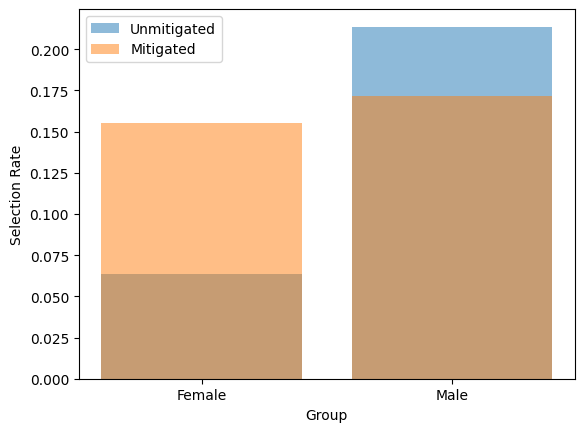

In [ ]:
import matplotlib.pyplot as plt

# Unmitigated selection rate
sr_unmitigated = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred, sensitive_features=sex)

# Mitigated selection rate
sr_mitigated = MetricFrame(metrics=selection_rate, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sex)

# Get the results by group
unmitigated_by_group = sr_unmitigated.by_group
mitigated_by_group = sr_mitigated.by_group

# Plot the results
groups = unmitigated_by_group.index
plt.bar(groups, unmitigated_by_group, alpha=0.5, label='Unmitigated')
plt.bar(groups, mitigated_by_group, alpha=0.5, label='Mitigated')
plt.xlabel('Group')
plt.ylabel('Selection Rate')
plt.legend()
plt.show()




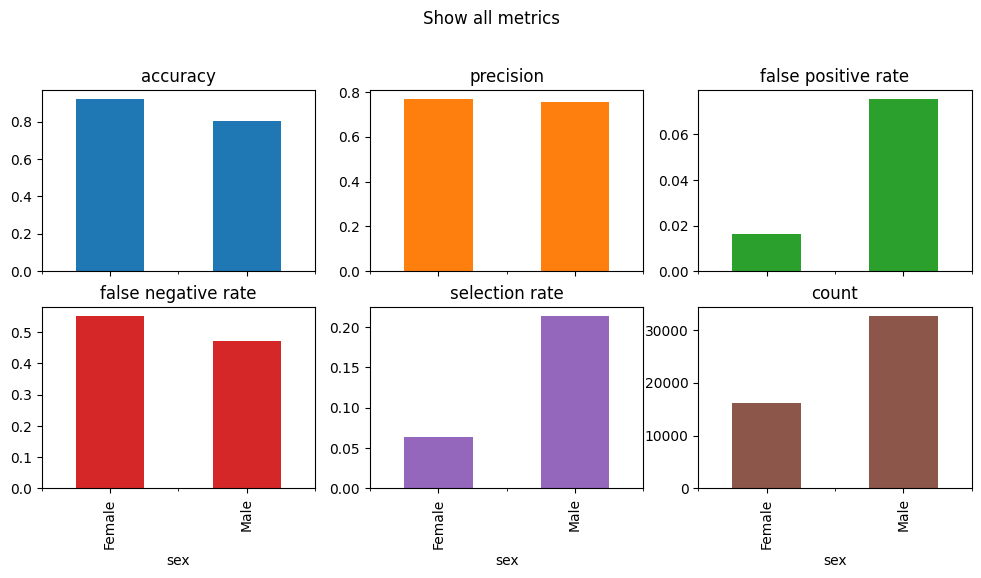

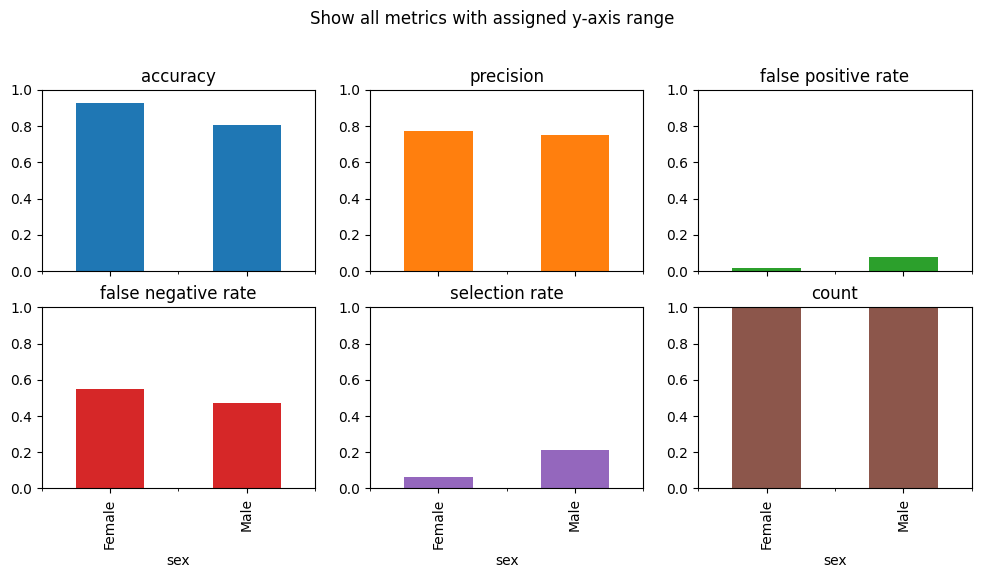

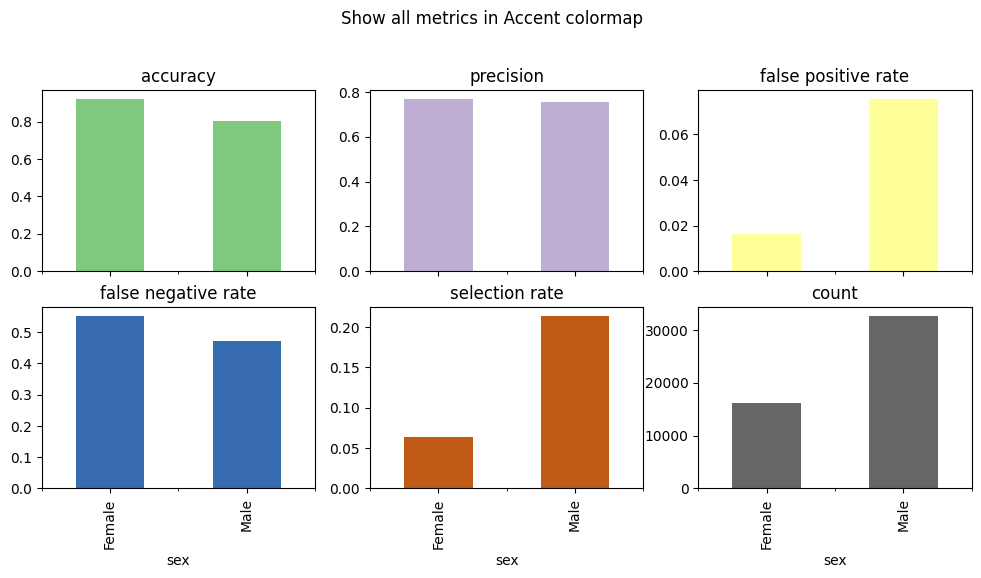

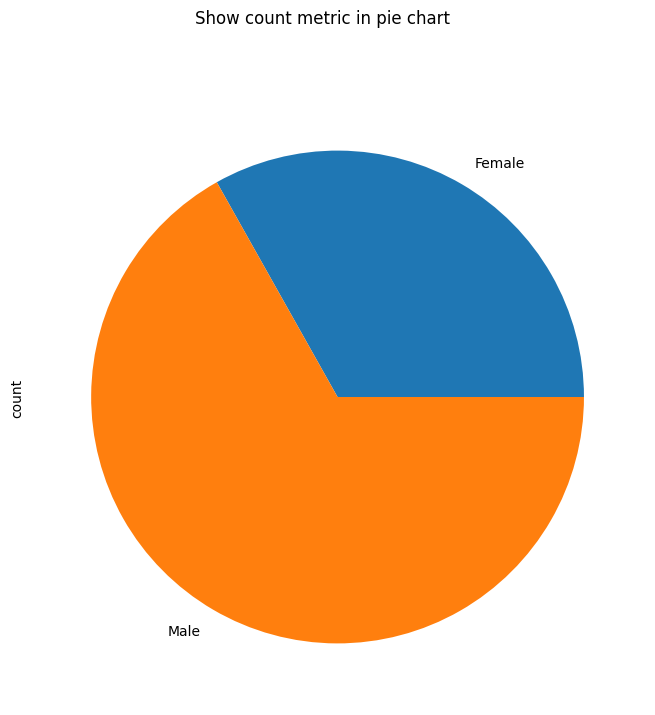

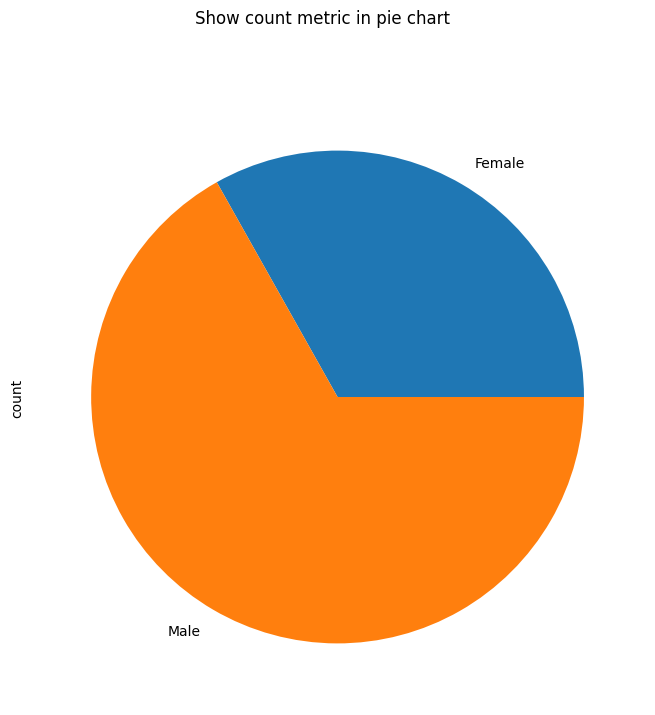

In [ ]:

from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

data = fetch_adult()
X = pd.get_dummies(data.data)
y_true = (data.target == ">50K") * 1
sex = data.data["sex"]

classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)
y_pred = classifier.predict(X)

# Analyze metrics using MetricFrame
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_true, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

# Customize plots with ylim
metric_frame.by_group.plot(
    kind="bar",
    ylim=[0, 1],
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics with assigned y-axis range",
)

# Customize plots with colormap
metric_frame.by_group.plot(
    kind="bar",
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    colormap="Accent",
    title="Show all metrics in Accent colormap",
)

# Customize plots with kind (note that we are only plotting the "count" metric here because we are showing a pie chart)
metric_frame.by_group[["count"]].plot(
    kind="pie",
    subplots=True,
    layout=[1, 1],
    legend=False,
    figsize=[12, 8],
    title="Show count metric in pie chart",
)

# Saving plots
fig = metric_frame.by_group[["count"]].plot(
    kind="pie",
    subplots=True,
    layout=[1, 1],
    legend=False,
    figsize=[12, 8],
    title="Show count metric in pie chart",
)

# Don't save file during doc build
if "__file__" in locals():
    fig[0][0].figure.savefig("filename.png")